In [1]:
import logging

logging.basicConfig(filename='log/model_validation.log', filemode='w', format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S', level=logging.INFO)
logging.info('PROCESSO INICIADO')

In [2]:
import itertools
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.preprocessing import image

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
logging.info('BIBLIOTECAS IMPORTADAS')

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

  logging.info('AJUSTES DE USO DE GPU FINALIZADO COM SUCESSO')

In [4]:
model = tf.saved_model.load('./modelos/gerados/nude_classifier_saved')
infer = model.signatures["serving_default"]
chave = list(infer.structured_outputs.keys())[0]
print(infer.structured_outputs)

logging.info('MODELO IMPORTADO COM SUCESSO')

{'dense_3': TensorSpec(shape=(None, 2), dtype=tf.float32, name='dense_3')}


In [5]:
test_dir = 'C:\\Users\\guilo\\mba-tcc\\data\\test'
image_size = 299
x_test = []
y_test = []
predictions = []
file_count = 0
update_frequency = 500

logging.info('AUXILIARES CONFIGURADOS COM SUCESSO')

In [6]:
class_names = ['not_safe', 'safest']
logging.info('LABELS CONFIGURADOS COM SUCESSO')

In [7]:
logging.info('VALIDAÇÃO INICIADA')
for image_file in Path(test_dir).glob("**/*.jpg"):
    file_count += 1
    # Load the current image file
    image_data = image.load_img(image_file, target_size=(image_size, image_size))

    # Convert the loaded image file to a numpy array
    image_array = image.img_to_array(image_data)
    image_array /= 255

    # Add to list of test images
    x_test.append(image_array)

    x_evaluate = []
    x_evaluate.append(image_array)
    
    valid = infer(tf.constant(np.array(x_evaluate)))
    predictions.append([valid[chave].numpy()[0][0], valid[chave].numpy()[0][1]])
    
    # Now add answer derived from folder
    path_name = os.path.dirname(image_file)
    folder_name = os.path.basename(path_name)
    y_test.append(class_names.index(folder_name))

    if file_count % update_frequency == 0:
        print("Qtd Importada: " + str(file_count) + " - Classe Atual: " + folder_name + " - Pasta Analisada: " + path_name)
        logging.info("Qtd Importada: " + str(file_count) + " - Classe Atual: " + folder_name + " - Pasta Analisada: " + path_name)

logging.info('VALIDAÇÃO FINALIZADA')

Qtd Importada: 500 - Classe Atual: not_safe - Pasta Analisada: C:\Users\guilo\mba-tcc\data\test\not_safe
Qtd Importada: 1000 - Classe Atual: not_safe - Pasta Analisada: C:\Users\guilo\mba-tcc\data\test\not_safe
Qtd Importada: 1500 - Classe Atual: not_safe - Pasta Analisada: C:\Users\guilo\mba-tcc\data\test\not_safe
Qtd Importada: 2000 - Classe Atual: not_safe - Pasta Analisada: C:\Users\guilo\mba-tcc\data\test\not_safe
Qtd Importada: 2500 - Classe Atual: not_safe - Pasta Analisada: C:\Users\guilo\mba-tcc\data\test\not_safe
Qtd Importada: 3000 - Classe Atual: not_safe - Pasta Analisada: C:\Users\guilo\mba-tcc\data\test\not_safe
Qtd Importada: 3500 - Classe Atual: not_safe - Pasta Analisada: C:\Users\guilo\mba-tcc\data\test\not_safe
Qtd Importada: 4000 - Classe Atual: not_safe - Pasta Analisada: C:\Users\guilo\mba-tcc\data\test\not_safe
Qtd Importada: 4500 - Classe Atual: not_safe - Pasta Analisada: C:\Users\guilo\mba-tcc\data\test\not_safe
Qtd Importada: 5000 - Classe Atual: not_safe - 

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.get_cmap('Blues')):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Classe Real')
    plt.xlabel('Classe Predita')
    plt.tight_layout()

In [9]:
logging.info('VALIDAÇÃO DAS CLASSES INICIADA')
x_test = np.array(x_test)
y_pred = np.argmax(predictions, axis=1)
logging.info('VALIDAÇÃO DAS CLASSES FINALIZADA')

In [10]:
print(classification_report(y_test, y_pred, target_names=class_names))
logging.info('RELATÓRIO DE CLASSIFICAÇÃO GERADO COM SUCESSO')

              precision    recall  f1-score   support

    not_safe       0.98      0.92      0.95      5000
      safest       0.89      0.97      0.93      3500

    accuracy                           0.94      8500
   macro avg       0.94      0.95      0.94      8500
weighted avg       0.95      0.94      0.94      8500



In [11]:
logging.info('MATRIZ DE CONFUSÃO CONFIGURADA COM SUCESSO')
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

Normalized confusion matrix


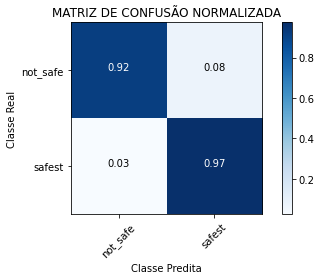

In [12]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='MATRIZ DE CONFUSÃO NORMALIZADA')

plt.show()
logging.info('MATRIZ DE CONFUSÃO NORMALIZADA GERADA COM SUCESSO')

Confusion matrix, without normalization


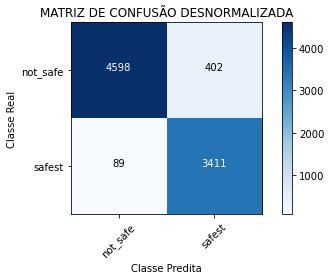

In [13]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False,
                      title='MATRIZ DE CONFUSÃO DESNORMALIZADA')

plt.show()
logging.info('MATRIZ DE CONFUSÃO DESNORMALIZADA GERADA COM SUCESSO')

In [14]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
logging.info('CURVA ROC CONFIGURADA COM SUCESSO')

In [15]:
auc_keras = auc(fpr_keras, tpr_keras)
logging.info('CURVA AUC CONFIGURADA COM SUCESSO')

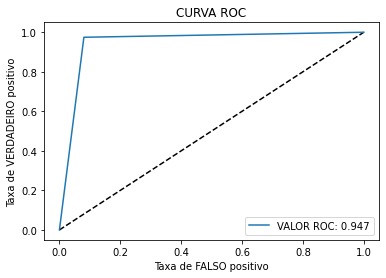

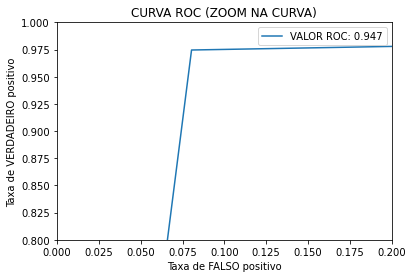

In [16]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='VALOR ROC: {:.3f}'.format(auc_keras))
plt.xlabel('Taxa de FALSO positivo')
plt.ylabel('Taxa de VERDADEIRO positivo')
plt.title('CURVA ROC')
plt.legend(loc='best')
plt.show();
logging.info('CURVA ROC GERADA COM SUCESSO')

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='VALOR ROC: {:.3f}'.format(auc_keras))
plt.xlabel('Taxa de FALSO positivo')
plt.ylabel('Taxa de VERDADEIRO positivo')
plt.title('CURVA ROC (ZOOM NA CURVA)')
plt.legend(loc='best')
plt.show();
logging.info('ZOOM DA CURVA ROC GERADA COM SUCESSO')

----

In [17]:
def predict_single_image(image_file):
    
    image_data = tf.keras.preprocessing.image.load_img(image_file, target_size=(299, 299))

    # Convert the loaded image file to a numpy array
    image_array = tf.keras.preprocessing.image.img_to_array(image_data)
    image_array /= 255

    plt.imshow(image_array);
    plt.axis('off');

    x_train = []
    x_train.append(image_array)
    x_test = np.array(x_train)

    predictions = infer(tf.constant(x_test))

    print('Not Safe: ', round(predictions['dense_3'].numpy()[0][0]*100, 2))
    print('Safe: ', round(predictions['dense_3'].numpy()[0][1]*100, 2))

    # return [predictions['dense_3'].numpy()[0][0], predictions['dense_3'].numpy()[0][1]]

Not Safe:  98.26
Safe:  1.74


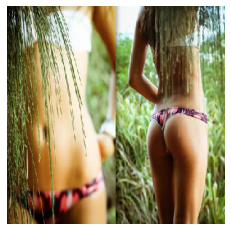

In [18]:
predict_single_image(r'C:\\Users\\guilo\\mba-tcc\\data\\validate\\not_safe\\not_safe_0.jpg')

Not Safe:  1.86
Safe:  98.14


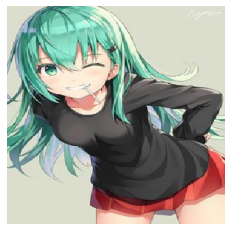

In [19]:
predict_single_image(r'C:\\Users\\guilo\\mba-tcc\\data\\validate\\safest\\safest_0.jpg')